In [74]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder

In [112]:
bank = pd.read_csv('bank-additional-full.csv', delimiter=';')
df = bank.copy()

In [113]:
print(df.shape)
df.head()

(41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [115]:
cat_columns = df.select_dtypes(include=object).columns
num_columns = df.select_dtypes(exclude=object).columns

In [116]:
for column in cat_columns:
    print(column)
    print(df[column].value_counts())
    print()

job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

marital
married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64

education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

default
no         32588
unknown     8597
yes            3
Name: default, dtype: int64

housing
yes        21576
no         18622
unknown      990
Name: housing, dtype: int64

loan
no         33950
yes         6248
unknown      990
Name: loan, dtype: int64

contact
cellular     26144
telephone    15044
Name: con

In [117]:
df['default'].value_counts()

no         32588
unknown     8597
yes            3
Name: default, dtype: int64

array([[<AxesSubplot: title={'center': 'age'}>,
        <AxesSubplot: title={'center': 'duration'}>,
        <AxesSubplot: title={'center': 'campaign'}>],
       [<AxesSubplot: title={'center': 'pdays'}>,
        <AxesSubplot: title={'center': 'previous'}>,
        <AxesSubplot: title={'center': 'emp.var.rate'}>],
       [<AxesSubplot: title={'center': 'cons.price.idx'}>,
        <AxesSubplot: title={'center': 'cons.conf.idx'}>,
        <AxesSubplot: title={'center': 'euribor3m'}>],
       [<AxesSubplot: title={'center': 'nr.employed'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

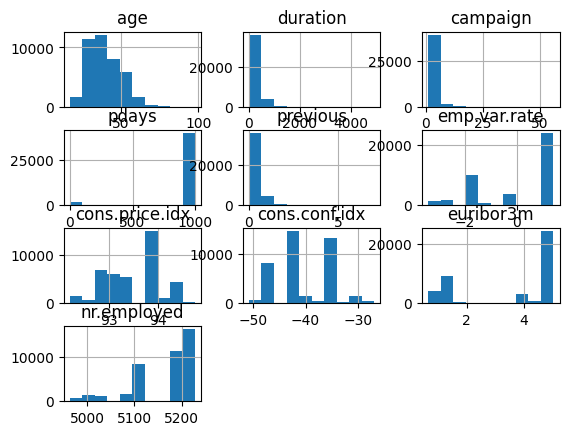

In [118]:
bank.hist()

In [119]:
dup_rows = df[df.duplicated()]
dup_rows

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
20216,55,services,married,high.school,unknown,no,no,cellular,aug,mon,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no
20534,41,technician,married,professional.course,no,yes,no,cellular,aug,tue,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,no
25217,39,admin.,married,university.degree,no,no,no,cellular,nov,tue,...,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,no
28477,24,services,single,high.school,no,yes,no,cellular,apr,tue,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.423,5099.1,no
32516,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,...,4,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no


12 duplicate entries

In [120]:
df.drop_duplicates(inplace=True)
df.shape

(41176, 21)

In [42]:
df['y'] = df['y'].apply(lambda x : 1 if x == 'yes' else 0)

Impute missing values using KNN

# Tests

### anova (> 2 categories) vs numerical
### chi sq cat vs cat logistic
### ttest (<= 2 categores) vs numrical or logistic

In [123]:
cat_cols = df.drop(['y'], axis = 1).select_dtypes(include = object).columns
cat_cols

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')

In [124]:
num_cols = df.select_dtypes(exclude = object).columns
num_cols

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

### Categorical

In [125]:
from scipy.stats import chi2_contingency

In [143]:
significant_columns = []
for column in cat_cols:
    contigency = pd.crosstab(df['y'], df[column])
    contigency
    c, p, dof, exp = chi2_contingency(contigency)
    if p < .05:
        significant_columns.append(column)
    print(column, p)

job 3.2684116066165443e-199
marital 1.778422500461116e-26
education 3.746768377534744e-38
default 5.2175408937279634e-89
housing 0.05663792749452545
loan 0.5771532081176227
contact 1.7187406241263769e-189
month 0.0
day_of_week 3.085754965631736e-05
poutcome 0.0


here we observe loan and housing are not showing any significant relation with our response variable, so we can drop those.

In [146]:
significant_columns

['job',
 'marital',
 'education',
 'default',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

In [182]:
cat_columns = significant_columns

### Numerical

In [157]:
from scipy.stats import ttest_ind

In [167]:
significant_n_columns = []
for column in num_cols:
    t_statistic, p_value = ttest_ind(df[df['y'] == 'no'][column], df[df['y'] == 'yes'][column])
    if p_value < 0.05:
        significant_n_columns.append(column)
    print(column, p_value)

age 7.003243845943398e-10
duration 0.0
campaign 2.043430909806966e-41
pdays 0.0
previous 0.0
emp.var.rate 0.0
cons.price.idx 1.6222328682353167e-169
cons.conf.idx 9.132175774883142e-29
euribor3m 0.0
nr.employed 0.0


all variables are significant

#### lets test with linear regression as well

In [160]:
x = df.copy()
x['y'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)

7.003243845943398e-10

In [176]:
import statsmodels.api as sm

# Fit the linear regression model (using statsmodel since sklearn doesn't provide p-values)
model = sm.OLS(x['y'], x[num_columns]).fit()

coefficients = model.params
p_values = model.pvalues
feature_names = x[num_columns].columns


In [178]:
results = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'P-value': p_values
})

print(results)

### check if there is any sort of ordering in the categorical column

In [ ]:
x = df.copy()
x['y'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)

In [ ]:
x.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [188]:
for column in cat_columns:
    print(x.groupby([column])['y'].mean().sort_values(), '\n')

job
blue-collar      0.068951
services         0.081422
entrepreneur     0.085165
housemaid        0.100000
self-employed    0.104856
technician       0.108325
unknown          0.112121
management       0.112175
admin.           0.129667
unemployed       0.142012
retired          0.252619
student          0.314286
Name: y, dtype: float64 

marital
married     0.101561
divorced    0.103231
single      0.140090
unknown     0.150000
Name: y, dtype: float64 

education
basic.9y               0.078246
basic.6y               0.082060
basic.4y               0.102490
high.school            0.108389
professional.course    0.113550
university.degree      0.137208
unknown                0.145087
illiterate             0.222222
Name: y, dtype: float64 

default
yes        0.000000
unknown    0.051536
no         0.128803
Name: y, dtype: float64 

contact
telephone    0.052324
cellular     0.147389
Name: y, dtype: float64 

month
may    0.064357
jul    0.090389
nov    0.101463
jun    0.105115
aug   

In [145]:
x.groupby(['housing'])['y'].mean().sort_values()

housing
unknown    0.108081
no         0.108783
yes        0.116221
Name: y, dtype: float64

# Preprocessing

In [86]:
df_encoded = pd.get_dummies(df.drop('y', axis = 1), columns= cat_columns)

In [87]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41176 entries, 0 to 41187
Data columns (total 63 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41176 non-null  int64  
 1   duration                       41176 non-null  int64  
 2   campaign                       41176 non-null  int64  
 3   pdays                          41176 non-null  int64  
 4   previous                       41176 non-null  int64  
 5   emp.var.rate                   41176 non-null  float64
 6   cons.price.idx                 41176 non-null  float64
 7   cons.conf.idx                  41176 non-null  float64
 8   euribor3m                      41176 non-null  float64
 9   nr.employed                    41176 non-null  float64
 10  job_admin.                     41176 non-null  uint8  
 11  job_blue-collar                41176 non-null  uint8  
 12  job_entrepreneur               41176 non-null 

# Models

In [88]:
#X = df.drop('y', axis = 1)
X = df_encoded
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [89]:
import xgboost as xbg

In [90]:
xgb_clf = xbg.XGBClassifier()

In [91]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [92]:
pre_ = xgb_clf.predict(X_train)
accuracy_score(y_train, pre_)

0.965237249429079

In [93]:
pre = xgb_clf.predict(X_test)

In [94]:
f1_score(y_test, pre)

0.5807365439093485

In [95]:
accuracy_score(y_test, pre)

0.9128707042460814

In [98]:
importance = xgb_clf.get_booster().get_score(importance_type='gain')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
print("Feature ranking:")
for i, (feature, score) in enumerate(sorted_importance):
    print(f"{i+1}. Feature {feature}: {score}")

Feature ranking:
1. Feature nr.employed: 127.75838470458984
2. Feature poutcome_success: 28.480283737182617
3. Feature duration: 12.202048301696777
4. Feature cons.conf.idx: 9.114739418029785
5. Feature month_may: 6.45294189453125
6. Feature month_oct: 5.968418598175049
7. Feature emp.var.rate: 5.725308418273926
8. Feature pdays: 4.993633270263672
9. Feature euribor3m: 4.925337791442871
10. Feature cons.price.idx: 4.062889099121094
11. Feature poutcome_failure: 3.934762477874756
12. Feature default_no: 3.7929763793945312
13. Feature contact_cellular: 3.6966235637664795
14. Feature education_basic.6y: 3.270745277404785
15. Feature job_blue-collar: 3.217576503753662
16. Feature day_of_week_tue: 3.120842456817627
17. Feature education_university.degree: 2.973722219467163
18. Feature day_of_week_mon: 2.8898117542266846
19. Feature marital_single: 2.8256876468658447
20. Feature month_jul: 2.812575101852417
21. Feature month_sep: 2.7596676349639893
22. Feature education_basic.4y: 2.720549821

In [99]:
from sklearn.linear_model import LogisticRegression

In [100]:
lr = LogisticRegression()

In [101]:
lr.fit(X_train, y_train)

/Users/nileshrathi/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [102]:
pre_ = lr.predict(X_train)

In [103]:
accuracy_score(y_train, pre_)

0.9093413564360024

In [104]:
pre = lr.predict(X_test)
accuracy_score(y_test, pre)

0.9077194789903599

In [105]:
from xgboost import plot_tree


In [ ]:
plot_tree(xgb_clf)
plt.show()

In [107]:
!pip install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 1.1 MB/s eta 0:00:00
